## Kaggle iceberg vs ship detector
https://www.kaggle.com/c/statoil-iceberg-classifier-challenge/overview  

---  

### Notes
- Visualize it
- Understand HH vs HV, incidence angle
- Denoise with sklearn, Lee filter, convolve()
- Augment data
- Use transfer learning - VGG16, Inception, ResNet50
- Check for imbalanced classes, use upsampling or SMOTE to address
- Don't use accuracy if classes are imbalanced. Use recall, F1, AUC

### References
- https://www.kaggle.com/jgroff/despeckling-synthetic-aperture-radar-sar-images
- https://www.kaggle.com/devm2024/keras-model-for-beginners-0-210-on-lb-eda-r-d
- https://www.kaggle.com/devm2024/transfer-learning-with-vgg-16-cnn-aug-lb-0-1712
- https://www.kaggle.com/knowledgegrappler/a-keras-prototype-0-21174-on-pl
- https://www.kaggle.com/cbryant/keras-cnn-statoil-iceberg-lb-0-1995-now-0-1516

### TODO
#### EDA
- [x] Visualize
- [x] Missing data
- [x] Unbalanced classes is_iceberg
- [x] Distribution of inc_angle
- [x] Summary stats

#### Data prep
- [x] Handle missing data in inc_angle. Impute or drop?
- [x] What to use for the 3rd channel? (average seems best)
- [x] Rescale the data (helped avoid lack of convergence)

#### CNN setup
- [x] Redo basic CNN
- [x] Record baseline
- [x] Transfer learning (didn't work, but maybe my fault)
- [x] Early stopping (yes, for tuning)
- [x] Cross validation (yes, for testing)
- [x] Tensorboard (great)

#### Data engineering
- [x] Denoise - scipy.ndimage median_filter (didn't help)
- [x] Denoise - Lee filter
- [x] Data augmentation (big lift)
- [x] Upsampling or SMOTE to address class imbalance
- [x] How to use inc_angle

#### CNN Tuning
- [x] Tune it

#### Analysis
- [x] Log loss
- [x] Evaluate impact of data engineering, CNN tuning
- [x] Precision, recall, F1 score, confusion matrix
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy.ndimage import convolve, uniform_filter, median_filter
from random import randint

In [2]:
# Import the sample submission file
sample_sub = pd.read_csv('data/sample_submission.csv')
sample_sub

,id,is_iceberg
0,5941774d,0.5
1,4023181e,0.5
2,b20200e4,0.5
3,e7f018bb,0.5
4,4371c8c3,0.5
...,...,...
8419,16ee9b50,0.5
8420,5a599eb7,0.5
8421,df30d6dd,0.5
8422,18af95b1,0.5


In [3]:
# Import the training data
train_df = pd.read_json('data/train.json')
train_df

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0
...,...,...,...,...,...
1599,04e11240,"[-30.999878, -29.976866, -28.233906, -29.50732...","[-27.847719, -28.233864, -24.712077999999998, ...",na,0
1600,c7d6f6f8,"[-25.31155, -26.511555, -28.694487, -27.180115...","[-29.563713, -28.290375, -26.839405, -28.29046...",na,0
1601,bba1a0f1,"[-18.141895, -18.141844, -19.01737, -19.701599...","[-25.305355, -29.387701, -28.963863, -26.16023...",na,0
1602,7f66bb44,"[-22.455633, -25.794661, -26.954567, -22.83354...","[-26.070356, -22.093737, -21.577662, -24.53376...",na,0


In [4]:
# Import the test data
test_df = pd.read_json('data/test.json')
test_df

,id,band_1,band_2,inc_angle
0,5941774d,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",34.966400
1,4023181e,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",32.615072
2,b20200e4,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",37.505433
3,e7f018bb,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",34.473900
4,4371c8c3,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",43.918874
...,...,...,...,...
8419,16ee9b50,"[-25.082357, -26.71583, -24.599827, -25.082571...","[-25.860718, -23.29442, -25.860861, -25.334354...",34.795500
8420,5a599eb7,"[-21.031391143798828, -21.031391143798828, -21...","[-23.755836486816406, -23.755836486816406, -23...",32.246683
8421,df30d6dd,"[-28.609278, -26.514626, -26.514679, -26.83061...","[-28.609278, -29.437183, -30.35239, -31.375494...",39.503200
8422,18af95b1,"[-27.068821, -27.068892, -23.970854, -22.38730...","[-29.991381, -29.163599, -24.886002, -27.71266...",33.638000


In [5]:
# Make 3D arrays of the image data
X_band_1 = np.array([np.array(band_1).astype(np.float32).reshape(75, 75) for band_1 in train_df["band_1"]])
X_band_2 = np.array([np.array(band_2).astype(np.float32).reshape(75, 75) for band_2 in train_df["band_2"]])

In [6]:
# Check the shapes
print(X_band_1.shape)
print(X_band_2.shape)

(1604, 75, 75)
(1604, 75, 75)


In [7]:
# Let's look at an image
X_band_1[0]

array([[-27.87836 , -27.15416 , -28.668615, ..., -25.573483, -26.488674,
        -30.507013],
       [-28.66853 , -27.8784  , -27.508776, ..., -26.488632, -28.671562,
        -31.594166],
       [-28.66853 , -27.15416 , -25.865042, ..., -27.157106, -27.881393,
        -32.837124],
       ...,
       [-29.092905, -28.669163, -30.504612, ..., -30.011005, -25.868538,
        -26.489265],
       [-31.591682, -27.878992, -28.669205, ..., -27.512272, -26.817074,
        -27.512358],
       [-29.092905, -26.814081, -27.15479 , ..., -26.817032, -27.881983,
        -28.268127]], dtype=float32)

In [8]:
# Look at datatypes
train_df.dtypes

id            object
band_1        object
band_2        object
inc_angle     object
is_iceberg     int64
dtype: object

In [9]:
# Cast inc_angle to float
for df in [train_df, test_df]:
    df['inc_angle'].replace('na', np.NaN, inplace=True)
    df['inc_angle'] = df['inc_angle'].astype(float)

In [10]:
train_df.describe()

,inc_angle,is_iceberg
count,1471.000000,1604.000000
mean,39.268707,0.469451
std,3.839744,0.499222
min,24.754600,0.000000
25%,36.106100,0.000000
50%,39.501500,0.000000
75%,42.559100,1.000000
max,45.937500,1.000000


In [11]:
test_df.describe()

,inc_angle
count,8424.000000
mean,40.153403
std,4.108386
min,23.080500
25%,36.905200
50%,40.375790
75%,43.472950
max,50.661785


In [12]:
# Look for missing inc_angle data
tr_nan_count = train_df['inc_angle'].isna().sum()
tr_nan_pct = tr_nan_count/train_df.shape[0]
print('NaN in train_df: ' + str(tr_nan_count) + ' (' + '{:.2%}'.format(tr_nan_pct) + ')')

ts_nan_count = test_df['inc_angle'].isna().sum()
ts_nan_pct = ts_nan_count/train_df.shape[0]
print('NaN in test_df: ' + str(ts_nan_count) + ' (' + '{:.2%}'.format(ts_nan_pct) + ')')

NaN in train_df: 133 (8.29%)
NaN in test_df: 0 (0.00%)


In [13]:
# Look for class imbalance in target feature
tr_pos_class_count = train_df['is_iceberg'].sum()
tr_pos_class_pct = tr_pos_class_count/train_df.shape[0]
print('Count of positive class in train_df: ' + str(tr_pos_class_count) + ' (' + '{:.2%}'.format(tr_pos_class_pct) + ')')

Count of positive class in train_df: 753 (46.95%)


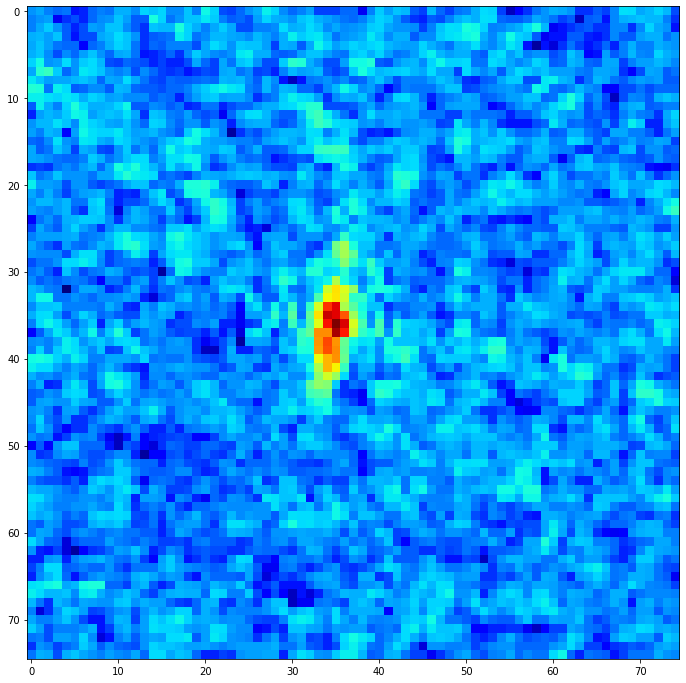

In [14]:
# Let's grab a random image and plot it
i = randint(0, X_band_1.shape[0])
fig, ax = plt.subplots(figsize=(12,12))
plt.imshow(X_band_1[0, :, :], cmap='jet');

In [15]:
# Is this an iceberg?
train_df.iloc[i]['is_iceberg']

0

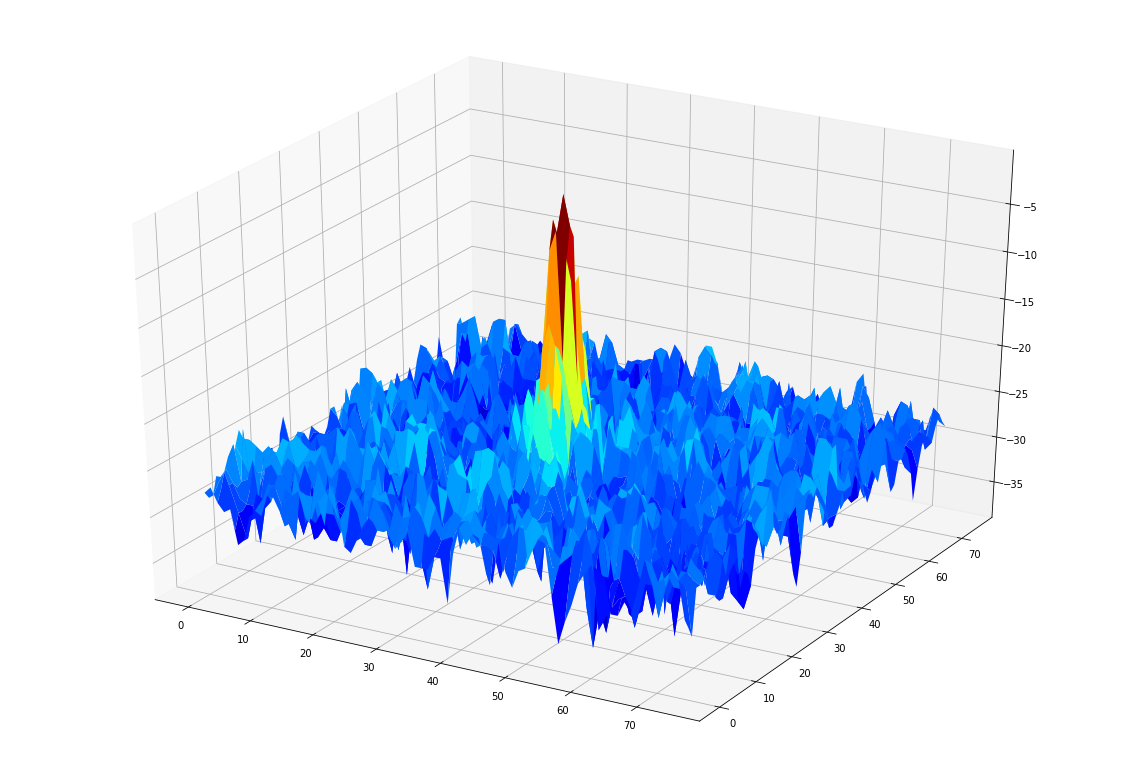

In [16]:
# Plot the image in 3D
fig = plt.figure(figsize=(20,14))
ax = fig.gca(projection='3d')

X = np.arange(0, 75)
Y = np.arange(0, 75)
X, Y = np.meshgrid(X, Y)
Z = X_band_1[0, :, :]

ax.plot_surface(X, Y, Z, cmap='jet',linewidth=0)

plt.show()

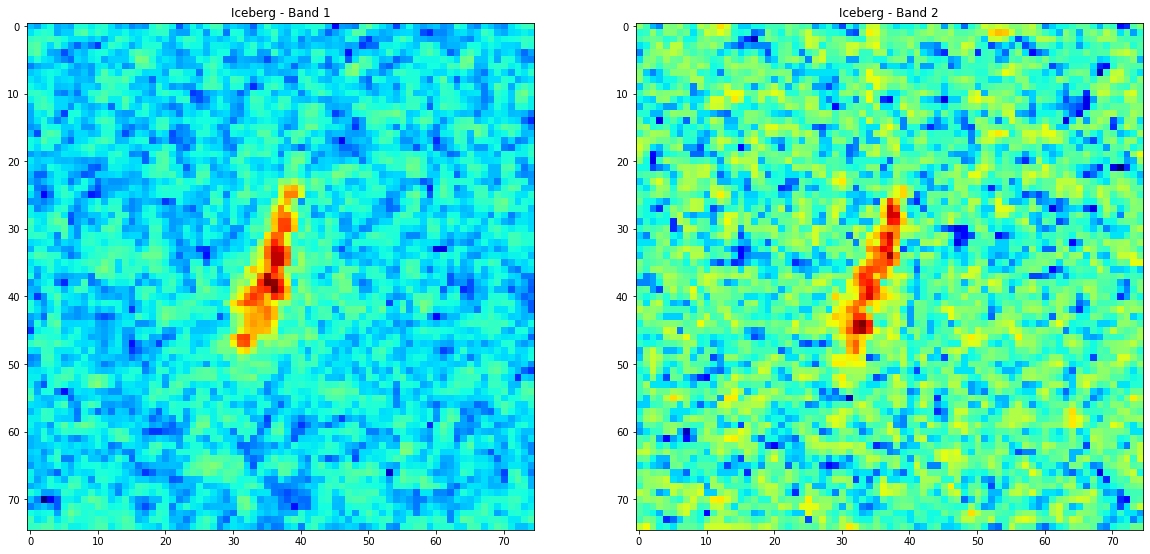

In [17]:
# Grab a random image, look at both bands
row = train_df.sample(1)
title_str = 'Iceberg' if row['is_iceberg'].values == 1 else 'Ship'

band_1= np.reshape(row['band_1'].values.tolist(),(75,75))
band_2= np.reshape(row['band_2'].values.tolist(),(75,75))

fig = plt.figure(0, figsize=(20,20))
ax = fig.add_subplot(1,2,1)
ax.set_title(title_str + ' - Band 1')
ax.imshow(band_1,cmap='jet')
ax = fig.add_subplot(1,2,2)
ax.set_title(title_str + ' - Band 2')
ax.imshow(band_2,cmap='jet')
plt.show()

---
### inc_angle correction

Images with higher incidence angle seem to have more noise, especially in band_2.  
See if we can fix correlation between noise and inc_angle.

In [18]:
train_df

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0
...,...,...,...,...,...
1599,04e11240,"[-30.999878, -29.976866, -28.233906, -29.50732...","[-27.847719, -28.233864, -24.712077999999998, ...",NaN,0
1600,c7d6f6f8,"[-25.31155, -26.511555, -28.694487, -27.180115...","[-29.563713, -28.290375, -26.839405, -28.29046...",NaN,0
1601,bba1a0f1,"[-18.141895, -18.141844, -19.01737, -19.701599...","[-25.305355, -29.387701, -28.963863, -26.16023...",NaN,0
1602,7f66bb44,"[-22.455633, -25.794661, -26.954567, -22.83354...","[-26.070356, -22.093737, -21.577662, -24.53376...",NaN,0


In [19]:
# Calculate median value of pixels per band. Stand in for overall brightness/noise.
train_df['band_1_median'] = [np.median(band_1) for band_1 in train_df['band_1']]
train_df['band_2_median'] = [np.median(band_2) for band_2 in train_df['band_2']]

In [20]:
# Cast inc_angle to float
train_df['inc_angle'].replace('na', np.NaN, inplace=True)
train_df['inc_angle'] = train_df['inc_angle'].astype(float)

In [21]:
# Look at correlation between inc_angle and median brightness.
# Pretty good (negative) correlation.
train_df[['band_1_median', 'band_2_median', 'inc_angle']].corr()

,band_1_median,band_2_median,inc_angle
band_1_median,1.000000,0.717997,-0.444304
band_2_median,0.717997,1.000000,-0.576480
inc_angle,-0.444304,-0.576480,1.000000


In [22]:
# Try to correct with cosine of inc_angle
train_df['cos_inc_angle'] = np.cos(np.deg2rad(train_df['inc_angle']))

In [23]:
train_df

,id,band_1,band_2,inc_angle,is_iceberg,band_1_median,band_2_median,cos_inc_angle
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0,-27.879921,-30.007847,0.720262
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0,-13.654199,-25.486130,0.786329
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1,-22.935019,-24.606205,0.703570
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0,-23.303238,-29.549923,0.721390
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0,-25.206615,-25.466921,0.812841
...,...,...,...,...,...,...,...,...
1599,04e11240,"[-30.999878, -29.976866, -28.233906, -29.50732...","[-27.847719, -28.233864, -24.712077999999998, ...",NaN,0,-28.639126,-29.510132,NaN
1600,c7d6f6f8,"[-25.31155, -26.511555, -28.694487, -27.180115...","[-29.563713, -28.290375, -26.839405, -28.29046...",NaN,0,-25.037895,-29.566250,NaN
1601,bba1a0f1,"[-18.141895, -18.141844, -19.01737, -19.701599...","[-25.305355, -29.387701, -28.963863, -26.16023...",NaN,0,-17.675674,-25.580650,NaN
1602,7f66bb44,"[-22.455633, -25.794661, -26.954567, -22.83354...","[-26.070356, -22.093737, -21.577662, -24.53376...",NaN,0,-20.631037,-24.302750,NaN


In [24]:
# Try cosine squared
train_df['cos2_inc_angle'] = np.cos(np.deg2rad(train_df['inc_angle']))**2

In [25]:
train_df

,id,band_1,band_2,inc_angle,is_iceberg,band_1_median,band_2_median,cos_inc_angle,cos2_inc_angle
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0,-27.879921,-30.007847,0.720262,0.518777
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0,-13.654199,-25.486130,0.786329,0.618314
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1,-22.935019,-24.606205,0.703570,0.495010
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0,-23.303238,-29.549923,0.721390,0.520404
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0,-25.206615,-25.466921,0.812841,0.660710
...,...,...,...,...,...,...,...,...,...
1599,04e11240,"[-30.999878, -29.976866, -28.233906, -29.50732...","[-27.847719, -28.233864, -24.712077999999998, ...",NaN,0,-28.639126,-29.510132,NaN,NaN
1600,c7d6f6f8,"[-25.31155, -26.511555, -28.694487, -27.180115...","[-29.563713, -28.290375, -26.839405, -28.29046...",NaN,0,-25.037895,-29.566250,NaN,NaN
1601,bba1a0f1,"[-18.141895, -18.141844, -19.01737, -19.701599...","[-25.305355, -29.387701, -28.963863, -26.16023...",NaN,0,-17.675674,-25.580650,NaN,NaN
1602,7f66bb44,"[-22.455633, -25.794661, -26.954567, -22.83354...","[-26.070356, -22.093737, -21.577662, -24.53376...",NaN,0,-20.631037,-24.302750,NaN,NaN


In [26]:
# Adjust bands 1 and 2
train_df['band_1_med_adjusted'] = train_df['band_1_median']*train_df['cos2_inc_angle']
train_df['band_2_med_adjusted'] = train_df['band_2_median']*train_df['cos2_inc_angle']

In [27]:
# Check correlation. Inconclusive.
train_df[['band_1_med_adjusted', 'band_2_med_adjusted', 'inc_angle']].corr()

,band_1_med_adjusted,band_2_med_adjusted,inc_angle
band_1_med_adjusted,1.000000,0.506668,0.116821
band_2_med_adjusted,0.506668,1.000000,0.749831
inc_angle,0.116821,0.749831,1.000000


In [28]:
# Also inconclusive
train_df[['band_1_median', 'band_2_median', 'cos2_inc_angle']].corr()

,band_1_median,band_2_median,cos2_inc_angle
band_1_median,1.000000,0.717997,0.443675
band_2_median,0.717997,1.000000,0.575365
cos2_inc_angle,0.443675,0.575365,1.000000


In [29]:
# Convert to radians?
train_df['tan_inc_angle'] = np.cos(np.deg2rad(train_df['inc_angle']))

In [30]:
# Try tangent
train_df['band_1_med_adjusted2'] = train_df['band_1_median']*train_df['tan_inc_angle']
train_df['band_2_med_adjusted2'] = train_df['band_2_median']*train_df['tan_inc_angle']

In [31]:
# Better but not great
train_df[['band_1_med_adjusted2', 'band_2_med_adjusted2', 'inc_angle']].corr()

,band_1_med_adjusted2,band_2_med_adjusted2,inc_angle
band_1_med_adjusted2,1.000000,0.574515,-0.182503
band_2_med_adjusted2,0.574515,1.000000,0.195124
inc_angle,-0.182503,0.195124,1.000000


---
### Denoise

In [32]:
# Convert from decibel to linear, converse
def decibel_to_linear(band):
    return np.power(10,np.array(band)/10)

def linear_to_decibel(band):
    return 10*np.log10(band)

In [33]:
# Lee filter for denoising
def lee_filter(band, window, var_noise = 0.25):
    mean_window = uniform_filter(band, window)
    mean_sqr_window = uniform_filter(band**2, window)
    var_window = mean_sqr_window - mean_window**2
    weights = var_window / (var_window + var_noise)
    band_filtered = mean_window + weights*(band - mean_window)
    return band_filtered

45.2859
Iceberg


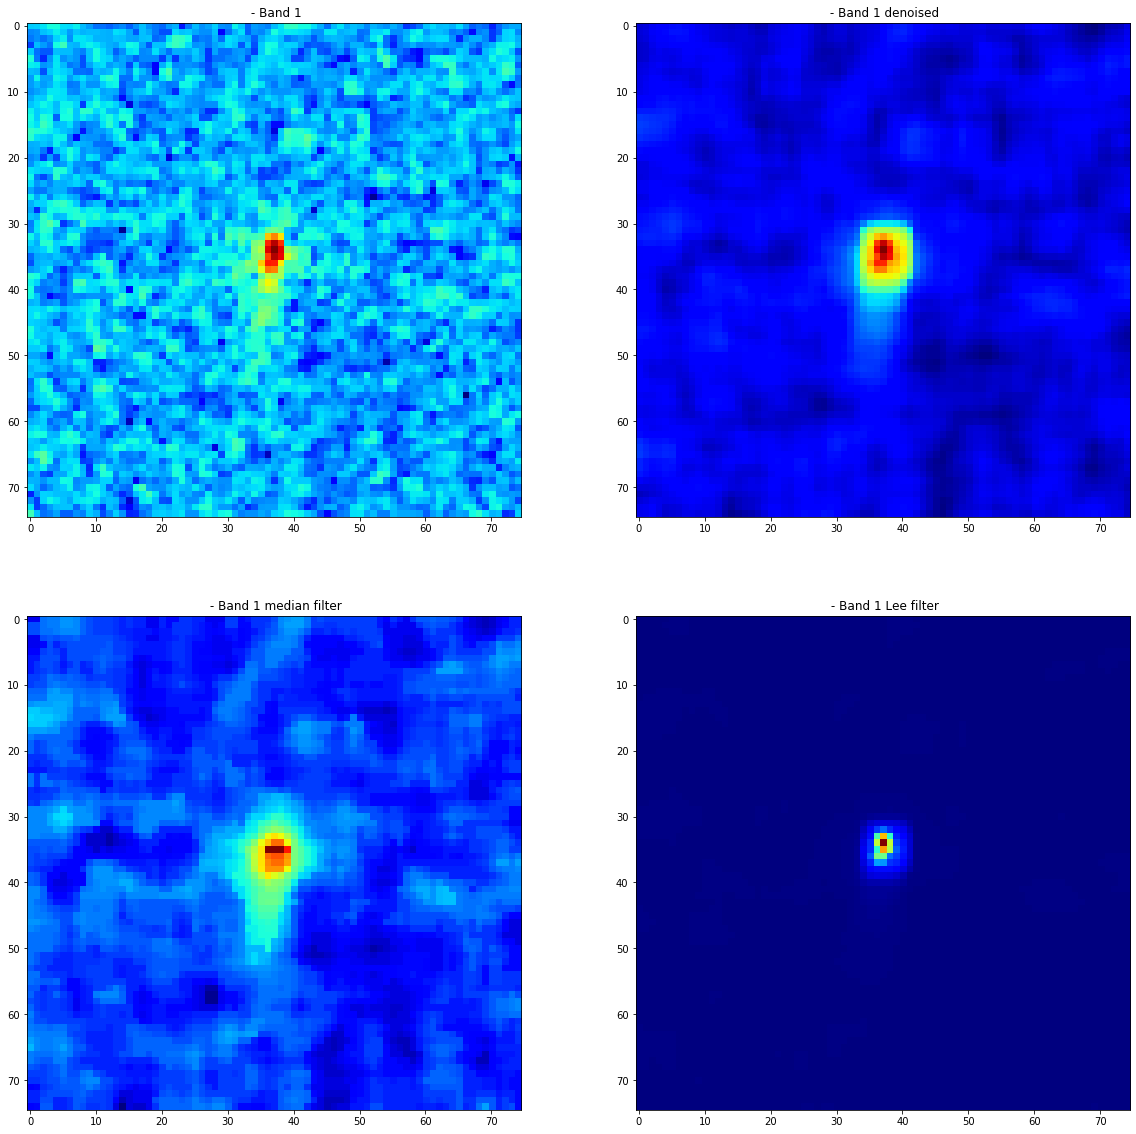

In [43]:
# Apply a few de-noising filters, look at results
#row = train_df.sample(1)
row = train_df.iloc[[244]]
print(row['inc_angle'].iloc[0])
print('Iceberg' if row['is_iceberg'].values == 1 else 'Ship')
title_str = ''

band_1= np.reshape(row['band_1'].values.tolist(),(75,75))
band_2= np.reshape(row['band_2'].values.tolist(),(75,75))

band_1_linear = decibel_to_linear(band_1)
band_2_linear = decibel_to_linear(band_2)

band_1_dn = linear_to_decibel(lee_filter(band_1_linear, 6))
band_2_dn = linear_to_decibel(lee_filter(band_2_linear, 6))

band_1_md = median_filter(np.array(band_1).reshape(75,75), size=(6,6))
band_2_md = median_filter(np.array(band_2).reshape(75,75), size=(6,6))

band_1_lee = lee_filter(band_1_linear, 6)
band_2_lee = lee_filter(band_2_linear, 6)

fig = plt.figure(0, figsize=(20,20))

rows = 2

ax = fig.add_subplot(rows,2,1)
ax.set_title(title_str + ' - Band 1')
ax.imshow(band_1,cmap='jet')

ax = fig.add_subplot(rows,2,2)
ax.set_title(title_str + ' - Band 1 denoised')
ax.imshow(band_1_dn,cmap='jet')

ax = fig.add_subplot(rows,2,3)
ax.set_title(title_str + ' - Band 1 median filter')
ax.imshow(band_1_md,cmap='jet')

ax = fig.add_subplot(rows,2,4)
ax.set_title(title_str + ' - Band 1 Lee filter')
ax.imshow(band_1_lee,cmap='jet')

plt.show()

---
### inc_angle distributions

In [35]:
# Convert inc_angle from string to float
train_df['inc_angle'].replace('na', np.NaN, inplace=True)
train_df['inc_angle'] = train_df['inc_angle'].astype(float)
test_df['inc_angle'].replace('na', np.NaN, inplace=True)
test_df['inc_angle'] = train_df['inc_angle'].astype(float)

In [36]:
# Check shapes
print(train_df.shape)
print(test_df.shape)

(1604, 14)
(8424, 4)


In [37]:
# What is the range of inc_angles
print(train_df['inc_angle'].max())
print(train_df['inc_angle'].min())

45.9375
24.7546


In [38]:
# Separate icebergs from non-icebergs in a range of inc_angles
start_angle = 36
end_angle = 40

tr_is_berg = train_df[(train_df['is_iceberg'] == 1) & (train_df['inc_angle'] > start_angle) & (train_df['inc_angle'] <= end_angle)]['inc_angle']
tr_not_berg = train_df[(train_df['is_iceberg'] == 0) & (train_df['inc_angle'] > start_angle) & (train_df['inc_angle'] <= end_angle)]['inc_angle']

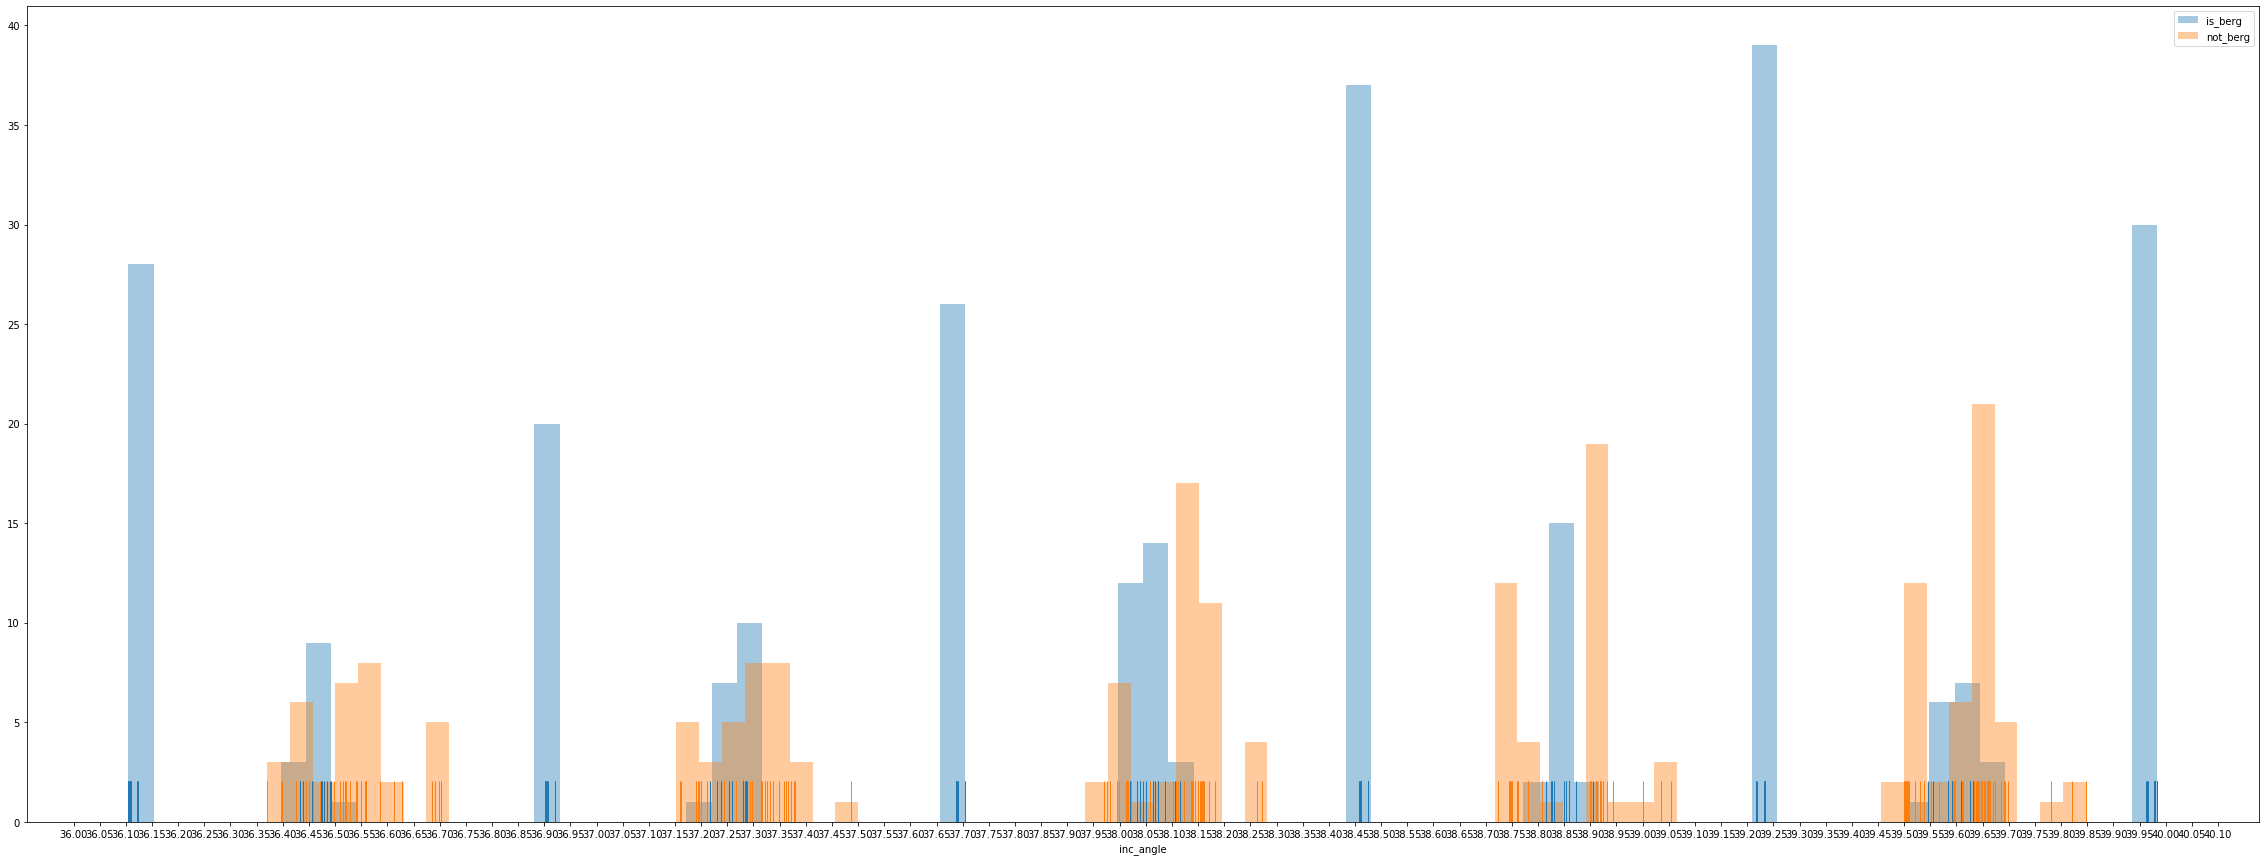

In [39]:
# Plot the distribution of icebergs vs ships in the given range, with bins of 0.05 degrees.
num_bins = int(np.ceil((end_angle - start_angle)/0.05))
fig, ax = plt.subplots(figsize=(40,15))
sns.distplot(tr_is_berg, kde=False, rug=True, bins=num_bins, label='is_berg')
sns.distplot(tr_not_berg, kde=False, rug=True, bins=num_bins, label='not_berg')
plt.xticks(np.arange(start_angle, end_angle+0.1, 0.05))
plt.legend();

---
### But now do it on test_df

In [40]:
print(test_df['inc_angle'].max())
print(test_df['inc_angle'].min())

45.9375
24.7546


In [41]:
# Grab all records in a range of inc_angles
ts_start_angle = 36
ts_end_angle = 40

ts_is_berg = test_df[(test_df['inc_angle'] > start_angle) & (test_df['inc_angle'] <= end_angle)]['inc_angle']

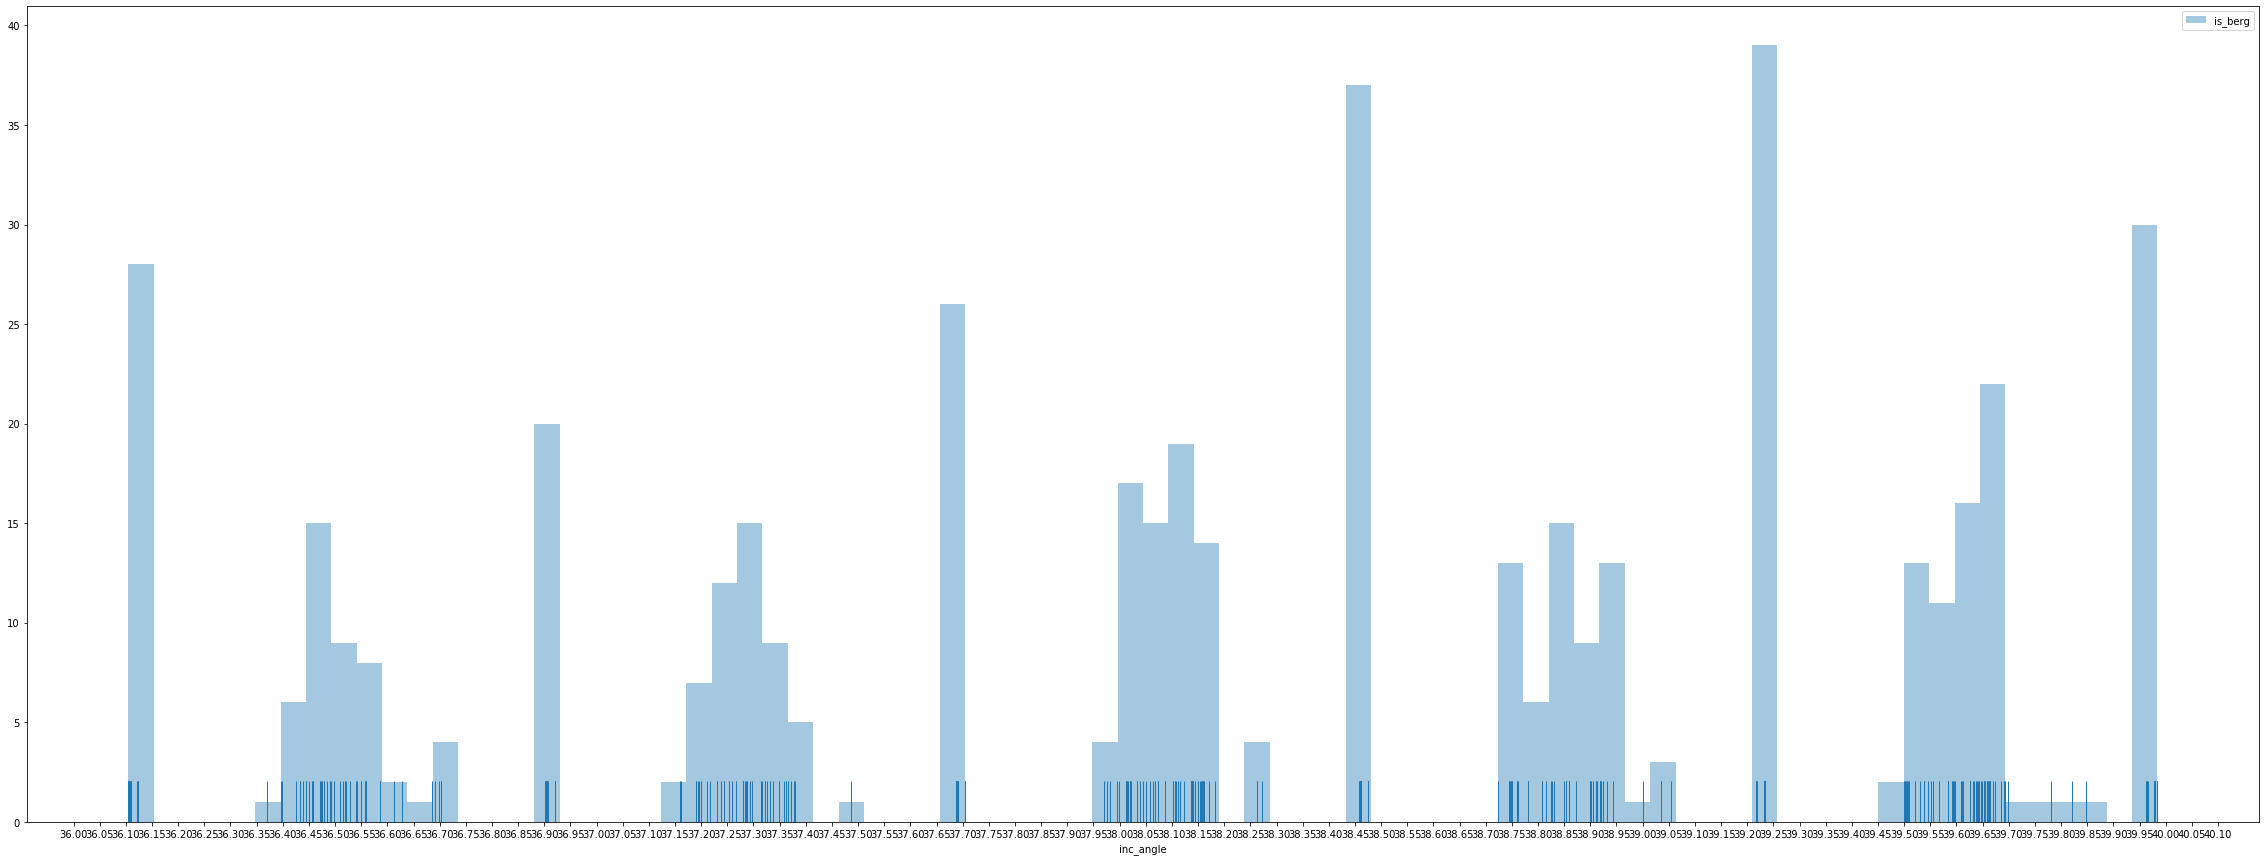

In [42]:
# Plot it in bins of 0.05 degrees inc_angle
num_bins = int(np.ceil((ts_end_angle - ts_start_angle)/0.05))
fig, ax = plt.subplots(figsize=(40,15))
sns.distplot(ts_is_berg, kde=False, rug=True, bins=num_bins, label='is_berg')
#sns.distplot(not_berg, kde=False, rug=True, bins=num_bins, label='not_berg')
plt.xticks(np.arange(start_angle, end_angle+0.1, 0.05))
plt.legend();